## xcube Data Store Framework - Climate Data Store

This notebook walks provides a walk-through demonstrating how to use xcube and the xcube Climate Data Store (CDS) plugin to read and explore temperature data from the CDS.

Please note: In order to be able to access data from the Climate Data Store, you need a CDS API key. 
#### You can obtain the UID and API key as follows:

1. Create a user account on the [CDS Website](https://cds.climate.copernicus.eu/user/register).
2. Log in to the website with your user name and password.
3. Navigate to your user profile on the website. Your API key is shown at the bottom of the page.

Please set `CDSAPI_URL` and `CDSAPI_KEY` as environment variables:

```
$ export CDSAPI_URL=https://cds.climate.copernicus.eu/api/v2
$ export CDSAPI_KEY=<UID>:<API-KEY>
```


In [1]:
# import os
# os.environ["CDSAPI_URL"] =  https://cds.climate.copernicus.eu/api/v2
# os.environ["CDSAPI_KEY"] = <UID>:<API-KEY>


In [2]:
from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store

from IPython.display import JSON

# For the orthographic map projection
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Configure matplotlib to display graphs inline directly in the notebook and set a sensible default figure size.

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 16,12


First, let's have a look at the data accessors. Which data accessors are available?

In [4]:
JSON({e.name: e.metadata for e in find_data_store_extensions()})

<IPython.core.display.JSON object>

In case 'cds' is not listed among the above stores, go to your terminal and 

```
$  conda install -c conda-forge xcube-cds
```

afterwards you need to restart the kernel and execute the lines above once more. Now cds should be in the store list. 

Usually we need more information to get the actual data store object. Which data store parameters are available?

In [5]:
get_data_store_params_schema('cds')

Provide mandatory parameters to instantiate the store class:

In [6]:
store = new_data_store('cds')
store

Which datasets are provided? (the list may contain both gridded and vector datasets):

In [7]:
JSON(list(store.get_data_ids()))

<IPython.core.display.JSON object>

Which "openers" are available? Note, the first part of an opener's name identifies the returned in-memory data type:

    dataset --> xarray.Dataset (Gridded data)
    mldataset --> xcube.core.mlds.MultiLevelDataset (Gridded data, multi-resolution pyramid)
    geodataframe --> geopandas.GeoDataFrame (Vector data)

The first opener is the default opener. In this case there is only a single one:


In [8]:
store.get_data_opener_ids()

('dataset:netcdf:cds',)

Get more info about a dedicated dataset. This include a description of the possible open formats:

In [9]:
store.describe_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis')

There are 4 required parameters, so we need to provide them to open a dataset:

In [10]:
dataset = store.open_data('reanalysis-era5-single-levels-monthly-means:monthly_averaged_reanalysis', 
                          variable_names=['2m_temperature'], 
                          bbox=[-10, 45, 40, 65], 
                          spatial_res=0.25, 
                          time_range=['2001-01-01', '2010-12-31'])
dataset

2020-11-18 11:48:48,851 INFO Welcome to the CDS
2020-11-18 11:48:48,853 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2020-11-18 11:48:49,465 INFO Request is queued
2020-11-18 11:48:50,694 INFO Request is running
2020-11-18 11:49:40,785 INFO Request is completed
2020-11-18 11:49:40,786 INFO Downloading http://136.156.133.42/cache-compute-0014/cache/data9/adaptor.mars.internal-1605696529.5488183-10190-28-68c46de9-f3ee-4dab-934a-9edde0bea7e2.nc to /tmp/tmpjvcjnqs3/tmpzy238l68/data (3.7M)
2020-11-18 11:49:45,826 INFO Download rate 744.7K/s 


<xarray.Dataset>
Dimensions:  (lat: 80, lon: 200, time: 120)
Coordinates:
  * lon      (lon) float32 -9.875 -9.625 -9.375 -9.125 ... 39.375 39.625 39.875
  * lat      (lat) float32 64.875 64.625 64.375 64.125 ... 45.625 45.375 45.125
  * time     (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2010-12-01
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-18 10:49:32 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Plot the differences between successive time points in the dataset. We can see that the times are monotonically increasing (all the difference values are positive), but not equally spaced, since months are not all of the same length. The lowest values correspond to February; the four-year leap year cycle can also be discerned.

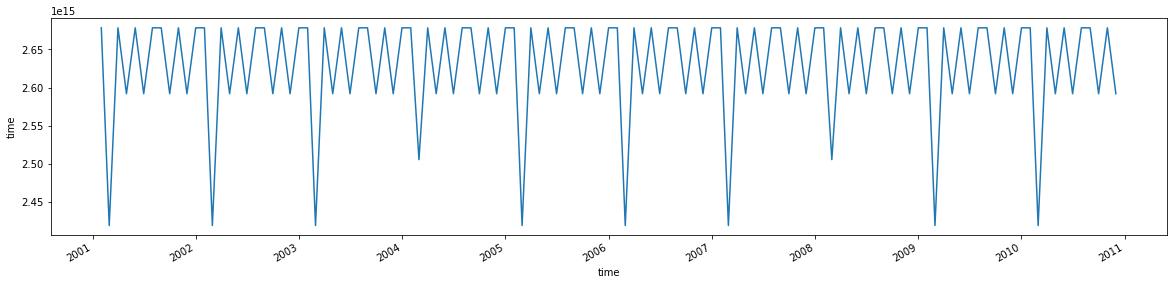

In [11]:
dataset.time.diff(dim='time').plot.line(figsize=(20, 4))

We can explore these data by plotting a temperature map for selected time points. First, we select January 2001. Land areas – and mountain ranges in particular – show up on the map as colder regions.

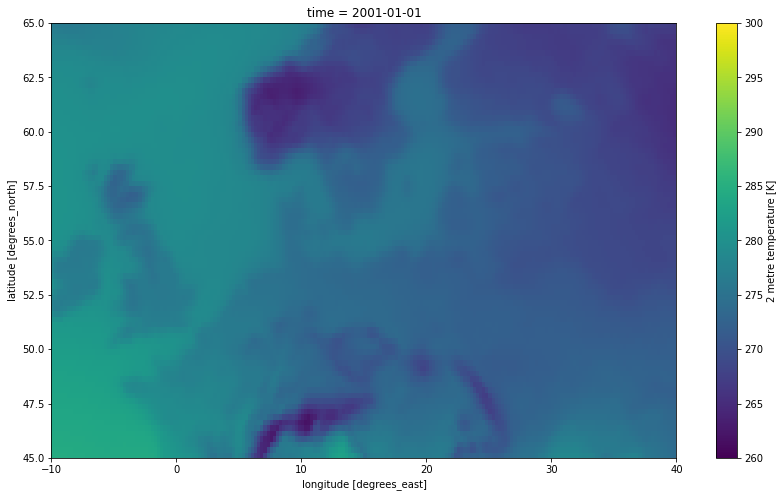

In [12]:
t2m_2001_jan = dataset.t2m.sel(time='2001-01-01 00:00:00', method='nearest')
t2m_2001_jan.plot.imshow(vmin=260, vmax=300, figsize=(14, 8))

For a more elegant and informative map, we define a function to plot a customized orthographic projection with overlaid coastlines and a grid.


In [13]:
def plot_map(data_array, colour_scale=(None, None), cmap=None):
    mid_lat = 55
    mid_lon = 15
    proj = ccrs.Orthographic(central_longitude=mid_lon, central_latitude=mid_lat)
    ax = plt.axes(projection=proj)
    im = data_array.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, vmin=colour_scale[0], vmax=colour_scale[1], cmap=cmap)
    ax.coastlines(resolution='50m')
    ax.set_extent((-1.9e6, 1.9e6, -1.1e6, 1.3e6), crs=proj)
    draw_labels = False  # only supported from cartopy 0.18.0 onwards
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=draw_labels, color='#000000', alpha=0.5, linestyle='--')
    gl.xlocator = mpl.ticker.FixedLocator([-10, 0, 10, 20, 30, 40])
    gl.ylocator = mpl.ticker.FixedLocator([40, 45, 50, 55, 60, 65])
    plt.colorbar(im, fraction=0.027, pad=0.04)

common_scale = (260, 300)

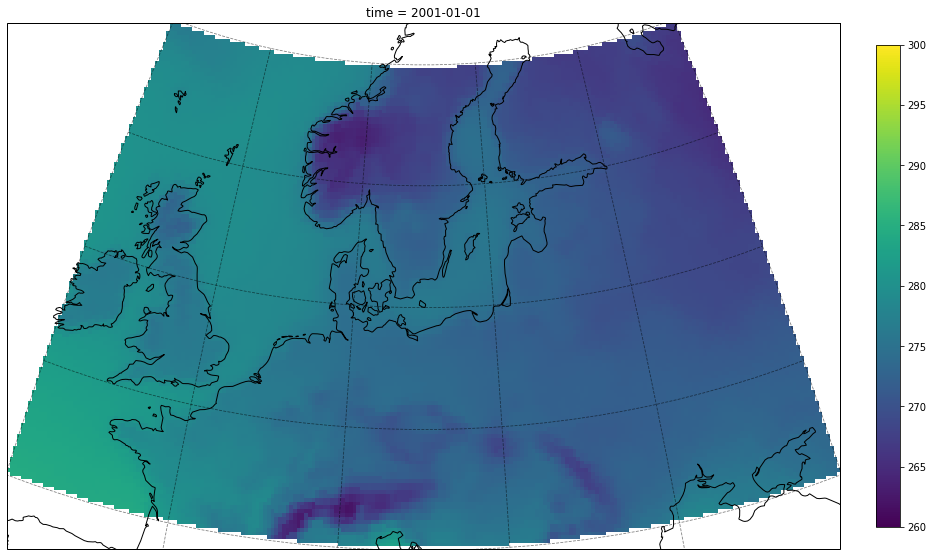

In [14]:
plot_map(t2m_2001_jan, common_scale)
